## Multivariate LSTM
Using the stateful LSTM network with 1 layer and 45 units (obtained in the [grid search notebook](https://github.com/anasashb/brent_price_forecasting/blob/main/univariate_lstm/1_tuning_stateful_lstm.ipynb)\). In this notebook we fit a multivariate model that besides the lagged brent data includes PMI index and Index of Global Industrial Activity. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Import stataments, including unused imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import regularizers
from keras.optimizers import Adam
import tensorflow as tf
import pickle

# Seeds
tf.random.set_seed(66)
np.random.seed(66)

# Plot configurations
plt.rcParams['figure.figsize'] = (12, 6.75)
plt.style.use('seaborn-v0_8')
plt.rcParams['font.size'] = 24

# Error metrics
def rmse(true, predicted):
    return np.sqrt(np.mean(np.square(predicted - true)))
def mape(true, predicted):
    true, predicted = np.array(true), np.array(predicted)
    return np.mean(np.abs((true - predicted) / true)) * 100




2023-07-26 14:34:21.609027: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Using TensorFlow backend.


### **Data:**

In [42]:
mvarpath = '/home/RDC/anasashb/Dokumente/ECXLOC/FIRSTMVAR.csv'
MVAR = pd.read_csv(mvarpath,
                   index_col = 'Date',
                   parse_dates = True)
MVAR.rename(columns={'EUR_Future_1_Month': 'BRENT'}, inplace=True)

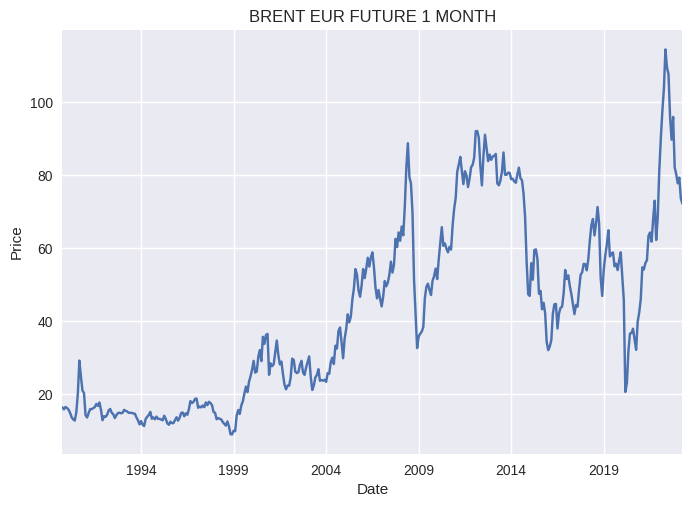

In [43]:
MVAR['BRENT'].plot()
plt.title('BRENT EUR FUTURE 1 MONTH')
plt.ylabel('Price')
plt.show()

In [45]:
# Drop unneeded columns
MVAR.drop(columns=
        [
        'EUR_Future_2_Month',
        'EUR_Future_3_Month',     
        ],
        inplace=True)

## These columns are already dropped in the multivariate set given in the repository. 

In [47]:
MVAR.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 403 entries, 1989-10-31 to 2023-04-28
Data columns (total 3 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   BRENT                                403 non-null    float64
 1   PMI                                  403 non-null    float64
 2   Index_of_Global_Industrial_Activity  403 non-null    float64
dtypes: float64(3)
memory usage: 12.6 KB


In [48]:
# Store dates index just in case
dates = MVAR.index

### **Pre-Processing for LSTM Input**
The pre-processing specifics --- such as set lengths --- of this case are essentially same as already described in the notebooks on univariate modeling

In [49]:
# Specify batch_size
batch_size = 10
# Specify lag order
timesteps = 1

In [50]:
# Manually set test size at 82 to make sure we have 80 predictions
test_size = 81
val_size = 51
train_size = 271
print(test_size+val_size+train_size)

403


In [51]:
# Train-val-test split
train = MVAR[:train_size]
val = MVAR[train_size:train_size+val_size]
test = MVAR[train_size+val_size:]

# Important to obtain the retrain set at this stage
# because we will lose observations if we concatenate 
# the sets after tensors have been generated
retrain = pd.concat((train, val), axis = 0)
# Check
len(train)+len(val)==len(retrain)



True

In [52]:
# Scaling for Multivariate

scaler_dict = {}

# Iterate over column names
for feature in MVAR.columns:
    # Fits on train 
    scaler = MinMaxScaler(feature_range=(-1, 1)).fit(train[[feature]])
    # Make transofrmations
    train[feature] = scaler.transform(train[[feature]])
    val[feature] = scaler.transform(val[[feature]])
    test[feature] = scaler.transform(test[[feature]])
    retrain[feature] = scaler.transform(retrain[[feature]])
    
    scaler_dict[feature] = scaler

In [53]:

# Reshape as LSTM inputs:
def generate_tensors(dataframe, timesteps):
    
    dataX, dataY = [], []
    
    for i in range(0, len(dataframe) - timesteps):
        x = dataframe.iloc[i: i + timesteps].values
        y = dataframe.iloc[i + timesteps]['BRENT']
        dataX.append(x)
        dataY.append(y)
    
    return np.array(dataX), np.array(dataY).reshape(-1,1)
                 

X_train, y_train = generate_tensors(train, timesteps)
X_val, y_val = generate_tensors(val, timesteps)
X_test, y_test = generate_tensors(test, timesteps)
X_retrain, y_retrain = generate_tensors(retrain, timesteps)

In [54]:
tensors = [X_train, y_train, X_val, y_val, X_test, y_test, X_retrain, y_retrain]

for i, tensor in enumerate(tensors):
    print(f'{tensor.shape}')

# Remove unneeded variable
del tensors

(270, 1, 3)
(270, 1)
(50, 1, 3)
(50, 1)
(80, 1, 3)
(80, 1)
(321, 1, 3)
(321, 1)


In [55]:
# Check divisibility of train set
remainder = len(y_train) % batch_size
print(remainder)

0


In [57]:
# Check divisibility of the retrain set
remainder_retrain = len(y_retrain) % batch_size
print(remainder_retrain)

1


In [58]:
# Trim retrain set
X_retrain, y_retrain = X_retrain[remainder_retrain:, :], y_retrain[remainder_retrain:, :]

# Check if worked
print(f'New shape of the training feature and target sets:\n {X_retrain.shape}\n {y_retrain.shape}\n')

New shape of the training feature and target sets:
 (320, 1, 3)
 (320, 1)



In [59]:
tensors = [X_train, y_train, X_val, y_val, X_test, y_test, X_retrain, y_retrain] 
# Final inspection of shapes
for i, tensor in enumerate(tensors):
    print(f'{tensor.shape}')

del tensors

(270, 1, 3)
(270, 1)
(50, 1, 3)
(50, 1)
(80, 1, 3)
(80, 1)
(320, 1, 3)
(320, 1)


In [60]:
# Path for saving results
path = '/home/RDC/anasashb/Dokumente/ECXLOC/ML1U45L1B10/Data/'

In [18]:
# Clean history to refit
del model
del history

In [107]:
# Model architecture as previously described, but for three inputs
model = Sequential()
model.add(LSTM(45,
                         activation = 'tanh',
                         recurrent_activation = 'sigmoid',
                         kernel_regularizer = regularizers.L2(1e-3),
                         recurrent_regularizer = regularizers.L2(1e-3),
                         bias_regularizer = regularizers.L2(1e-3),
                         recurrent_dropout=0,
                         unroll=False,
                         use_bias = True,
                         stateful = True,
                         return_sequences = False,
                         batch_input_shape = (batch_size, timesteps, 3) 
                         ))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mape'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (10, 45)                  8820      
_________________________________________________________________
dropout_8 (Dropout)          (10, 45)                  0         
_________________________________________________________________
dense_8 (Dense)              (10, 1)                   46        
Total params: 8,866
Trainable params: 8,866
Non-trainable params: 0
_________________________________________________________________


The model is trained with early stopping: 

In [109]:
# Set up variables for early stopping
best_train_loss = np.inf
patience = 10
wait = 0
min_delta = 0.001

# Empty containers to store training losses.
train_losses = []

# Training loop for 500 epochs
for i in range(500):
    history = model.fit(X_retrain,
                    y_retrain,
                    epochs = 1,
                    batch_size = batch_size,
                    verbose = 0)
    # Reset cell states after one epoch
    model.reset_states()
    
    # Calculate training losses
    train_loss = history.history['loss'][0]
    
    # Append losses
    train_losses.append(train_loss)
    
    # Check for early stopping
    if np.abs(train_loss - best_train_loss) > min_delta:
        best_train_loss = train_loss
        wait = 0
        
    else:
        wait += 1
        if wait >= patience:
            print(f'early stopping on epoch: {i}')
            
            break
    
    print(f'Epoch {i + 1} - Training Loss: {train_loss}')    
    

Epoch 1 - Training Loss: 0.44055837392807007
Epoch 2 - Training Loss: 0.3308560252189636
Epoch 3 - Training Loss: 0.26190561056137085
Epoch 4 - Training Loss: 0.19338512420654297
Epoch 5 - Training Loss: 0.1375671625137329
Epoch 6 - Training Loss: 0.09690000861883163
Epoch 7 - Training Loss: 0.0767475888133049
Epoch 8 - Training Loss: 0.06666150689125061
Epoch 9 - Training Loss: 0.06102926284074783
Epoch 10 - Training Loss: 0.056547582149505615
Epoch 11 - Training Loss: 0.054130326956510544
Epoch 12 - Training Loss: 0.049242258071899414
Epoch 13 - Training Loss: 0.046779561787843704
Epoch 14 - Training Loss: 0.04476035386323929
Epoch 15 - Training Loss: 0.04182714968919754
Epoch 16 - Training Loss: 0.040167249739170074
Epoch 17 - Training Loss: 0.037915583699941635
Epoch 18 - Training Loss: 0.036188166588544846
Epoch 19 - Training Loss: 0.034543417394161224
Epoch 20 - Training Loss: 0.03283240273594856
Epoch 21 - Training Loss: 0.03155846893787384
Epoch 22 - Training Loss: 0.0309283882

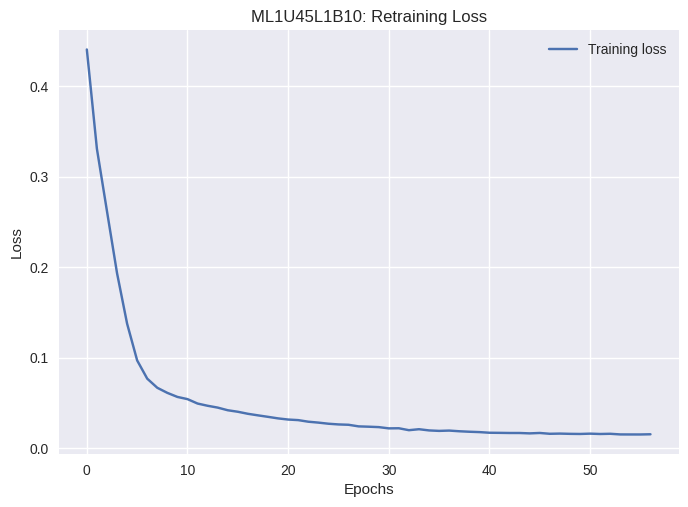

In [110]:
# Plot losses
plt.plot(train_losses, label='Training loss')
plt.title('ML1U45L1B10: Retraining Loss') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(path+'ML1U45L1B10_Retrain_Loss.png', dpi = 300, transparent = True) 
plt.show()
plt.close()

In [111]:
# Save model for re-use
model.save(path+'ML1U45L1B10.h5') # Rename

In [112]:
# Predict on test set
y_pred = model.predict(X_test, verbose = 0, batch_size = batch_size)

In [113]:
# Inspect scaler dictionary to grab the scaler for the target
scaler_dict

{'BRENT': MinMaxScaler(feature_range=(-1, 1)),
 'PMI': MinMaxScaler(feature_range=(-1, 1)),
 'Index_of_Global_Industrial_Activity': MinMaxScaler(feature_range=(-1, 1))}

In [114]:
# Load scaler from dict
target_scaler = scaler_dict['BRENT']

In [115]:
# Reverse scalings
y_pred = target_scaler.inverse_transform(y_pred)
y_test_unsc = target_scaler.inverse_transform(y_test)


Just to make sure, the shapes of the predicted and true values are (80, 1) and (80, 1)

The RMSE is: 5.861623959117483

The MAPE is: 8.533162859210892


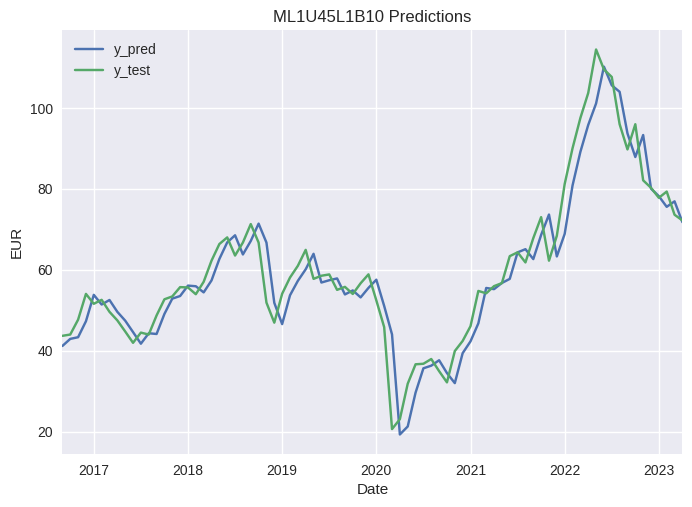

In [116]:
# Check shapes just in case.
print(f'\nJust to make sure, the shapes of the predicted and true values are {y_pred.shape} and {y_test_unsc.shape}')
print(f'\nThe RMSE is: {rmse(y_test_unsc, y_pred)}')
print(f'\nThe MAPE is: {mape(y_test_unsc, y_pred)}')


# Turn the predictions and true values into a plot
test_dates = dates[-len(y_test):]
df = pd.DataFrame({'y_pred': y_pred.flatten(), 'y_test': y_test_unsc.flatten()})
df.set_index(test_dates, inplace = True)
df.plot()
plt.title('ML1U45L1B10 Predictions') 
plt.savefig(path+'ML1U45L1B10_Forecast.png', transparent = True, dpi = 300) 
plt.ylabel('EUR') 
plt.show()
plt.close()

In [117]:
with open(path+'ML1U45L1B10_Results.pkl', 'wb') as f:
    pickle.dump(df, f)

In [118]:
# In sample prediction
ins = model.predict(X_retrain, verbose = 0, batch_size = batch_size)

# Reverse scalings
ins = target_scaler.inverse_transform(ins)
ins_true = target_scaler.inverse_transform(y_retrain)

# Check shapes just in case.
print(f'\nJust to make sure, the shapes of the predicted and true values are {ins.shape} and {ins_true.shape}')
print(f'\nThe RMSE is: {rmse(ins_true, ins)}')
print(f'\nThe MAPE is: {mape(ins_true, ins)}')


Just to make sure, the shapes of the predicted and true values are (320, 1) and (320, 1)

The RMSE is: 3.4946753086919045

The MAPE is: 7.690873450233182
